In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, create_info, set_log_level
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import AverageTFR

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif')

 CSP + LDA classification

In [3]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,35
Events,left: 19right: 16
Time range,-2.000 – 7.999 sec
Baseline,off


In [4]:
min_freq = 7.
max_freq = 140.
tmin = -1.8
tmax = 1.6
n_freqs = 10  # how many frequency bins to use
classes = list(subset.event_id.keys())

In [5]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
lda = LinearDiscriminantAnalysis()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=34)
le = LabelEncoder()

In [6]:
freqs = [2.,7.,18.,35.,60.,70.,90.,110.,120.,130,140]
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

In [7]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

Classification with different time, csp and freqs

In [8]:
scores = []
time_config = [
    (1,0.0,1600,0),
    (1,0.2,1200,0),
    (1,0.2,800,0),
    (1,0.4,800,0),
    (1,0.4,600,0),
    (1,0.4,400,0),
    (3,0.2,500,200),
    (3,0.4,500,200),
    (3,0.2,400,100),
    (3,0.4,400,200),
    (3,0.4,400,100),
    (3,0.2,300,0),
    (3,0.4,300,100),
]
components = [2,4,6,8,10,12,14]

In [9]:
count = 1
for cnf in time_config:
    print('running config',count,'.'*count)
    n_windows, t_min, width, overlap = cnf
    component_score = []
    for cmp in components:
        csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')
        freq_labels = []
        freq_scores = []
        for freq, (fmin, fmax) in enumerate(freq_ranges):
            X = []
            test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
            cv_split = cv.split(test)
            if tmin > 3 and (conditions[1] == 'rest'):
                rest = subset['rest'].copy().crop(0, tmax-tmin).filter(fmin, fmax, n_jobs=4, verbose=None)
                rest.drop_channels(rest.info['bads'])
                X = np.concatenate([test[condtion[0]].get_data(), rest.get_data()])

            single_scr = []
            for train_idx, test_idx in cv_split:
                y_train, y_test = y[train_idx], y[test_idx]
                X_train = []
                X_test = []
                csp.fit(test[train_idx], y_train)
                w_min = 0
                for i in range(n_windows):
                    w_max = w_min + width
                    X_train.append(csp.transform(test[train_idx,:,w_min:w_max]))
                    X_test.append(csp.transform(test[test_idx,:,w_min:w_max]))
                    w_min += w_max - overlap
                    
                X_train = np.concatenate(np.array(X_train), axis=1)
                X_test = np.concatenate(np.array(X_test), axis=1)
                lda.fit(X_train, y_train)
                single_scr.append(lda.score(X_test, y_test))
                
            freq_labels.append(str(int(fmax)))
            freq_scores.append(single_scr)    
        component_score.append(freq_scores)
    scores.append(component_score)
    count += 1

running config 1 .
running config 2 ..
running config 3 ...
running config 4 ....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 5 .....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 6 ......


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 7 .......
running config 8 ........


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 9 .........
running config 10 ..........


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 11 ...........


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

running config 12 ............
running config 13 .............


C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3840476481.py:12: RuntimeWarning: filter_le

In [10]:
scores_arr = np.array(scores)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_5892\3722807605.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  csp_fig, axes = plt.subplots(1)


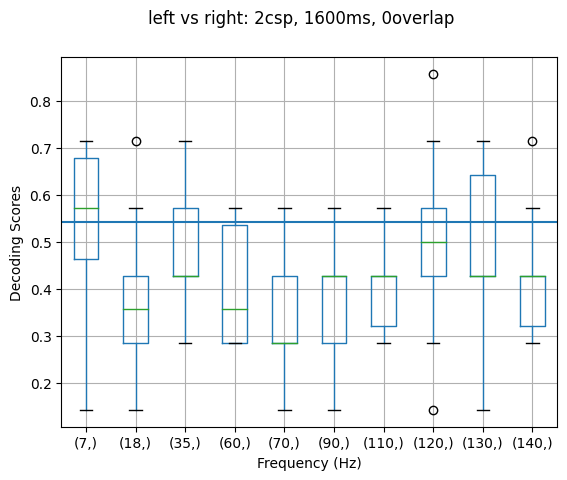

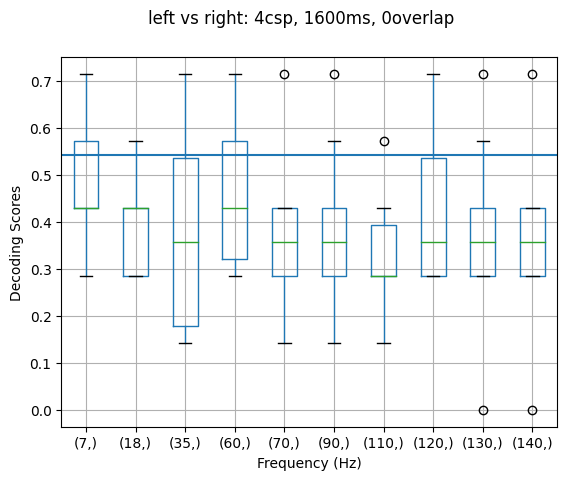

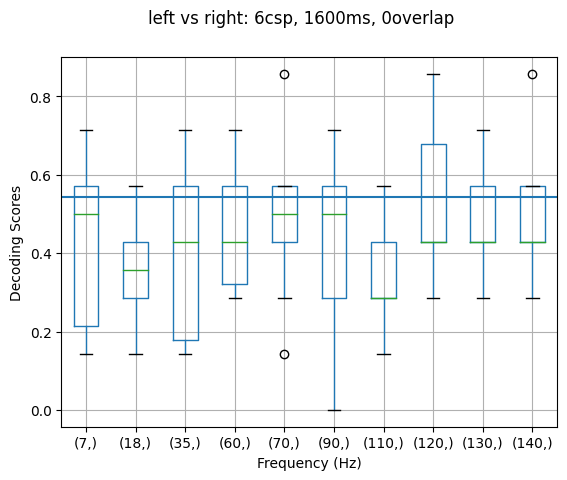

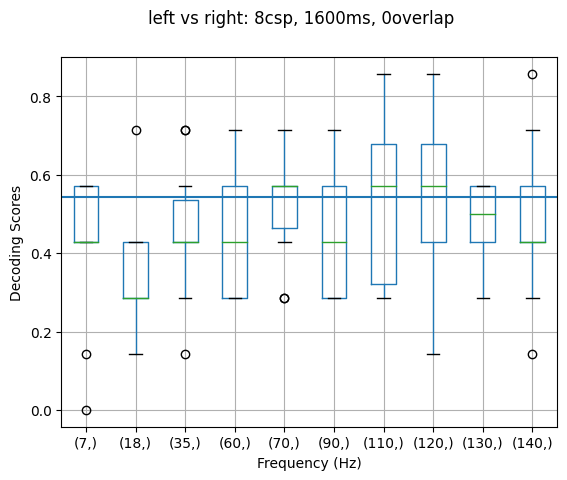

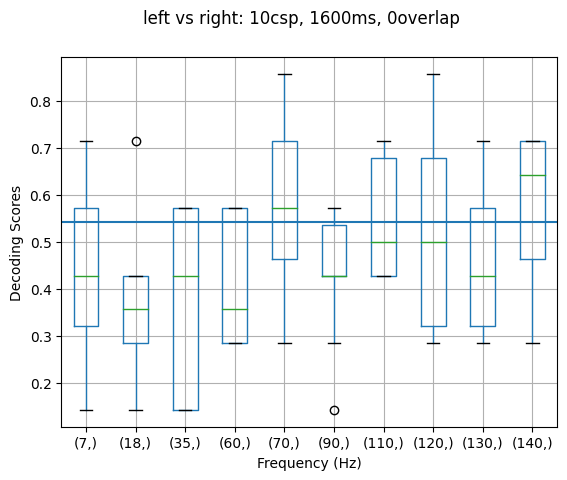

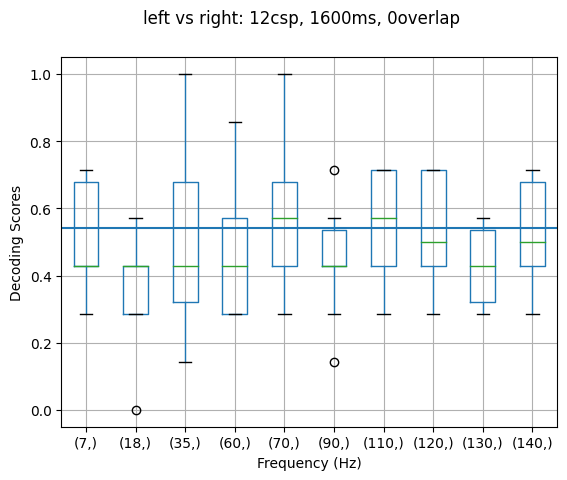

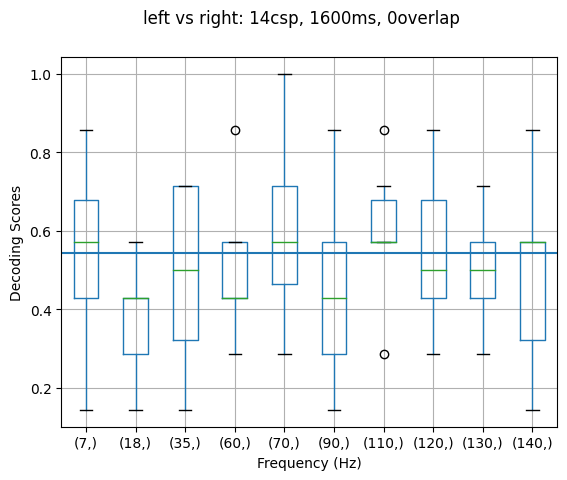

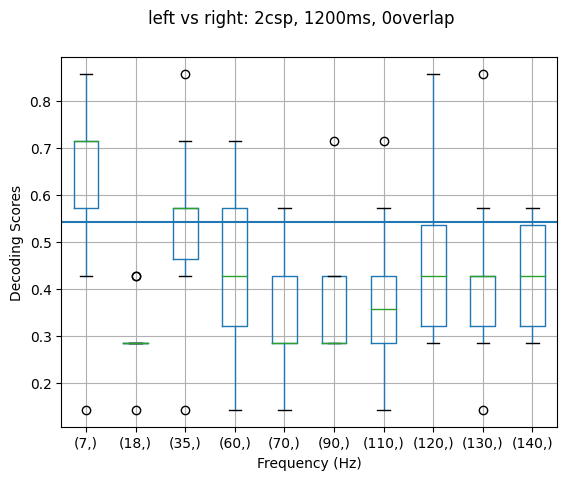

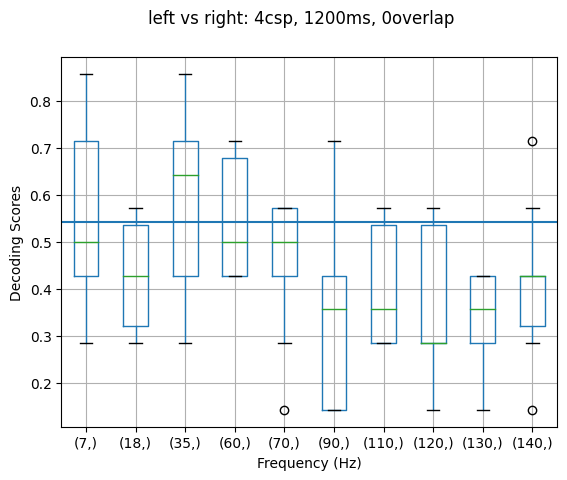

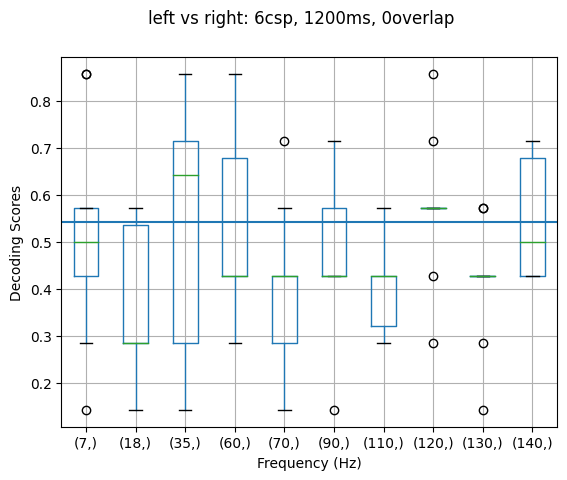

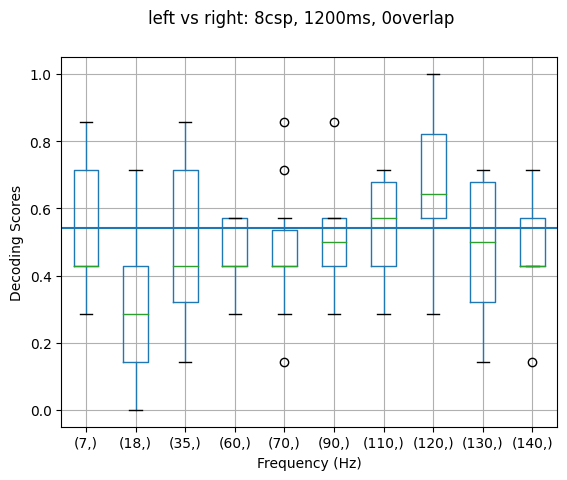

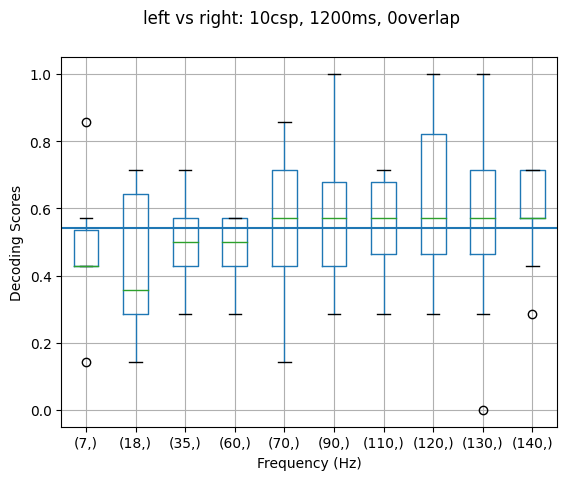

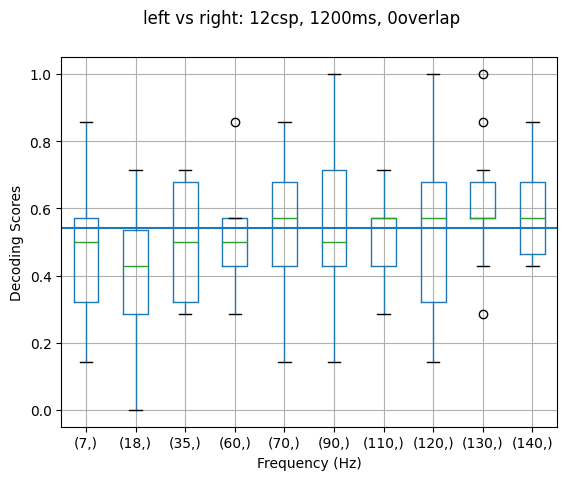

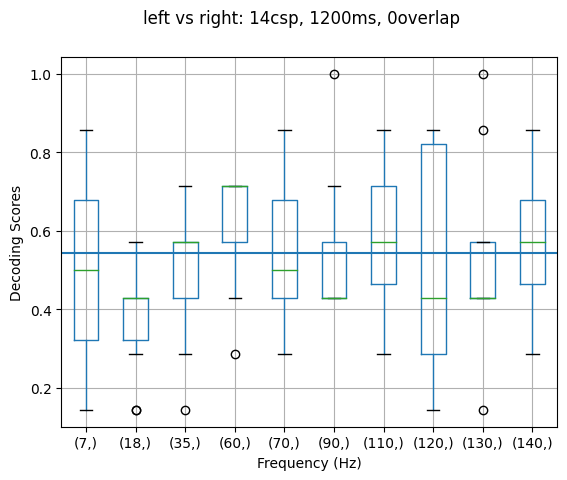

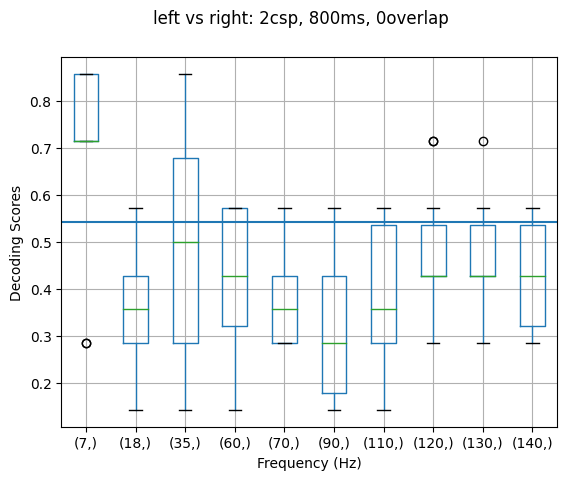

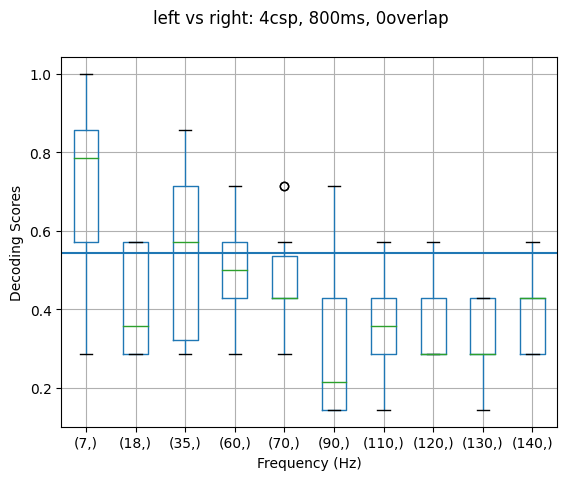

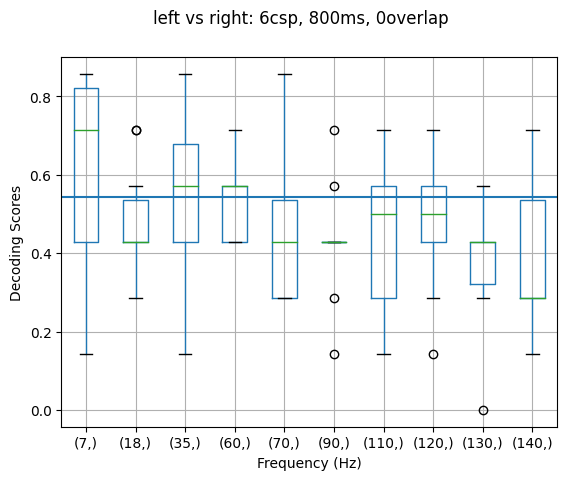

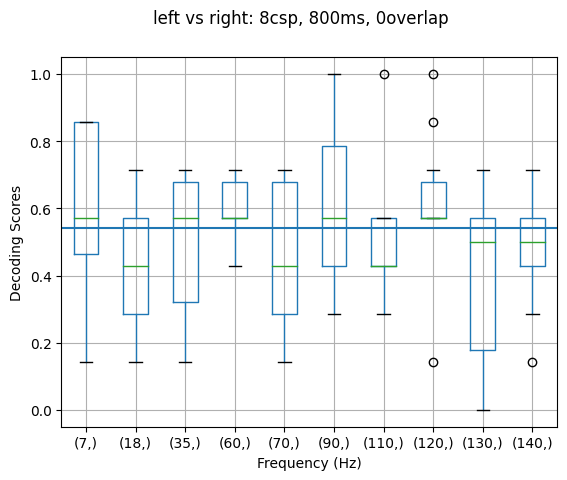

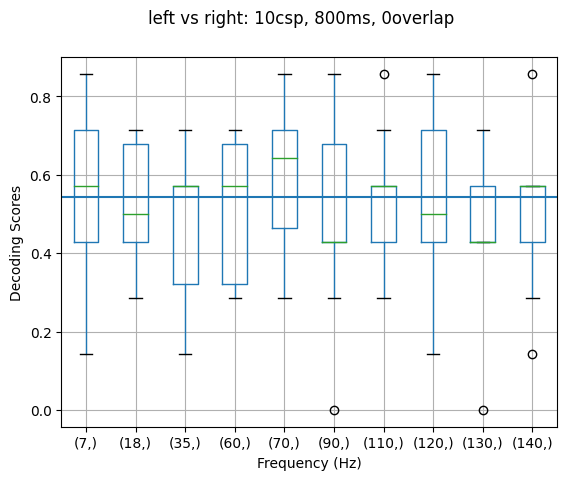

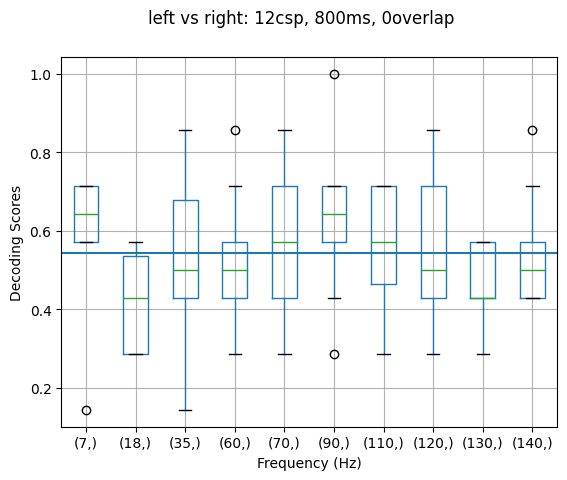

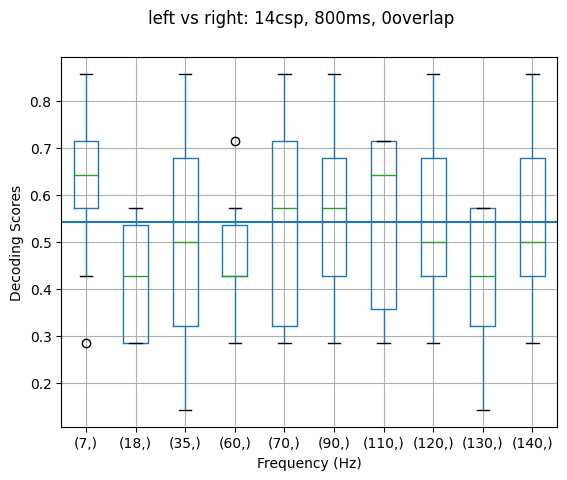

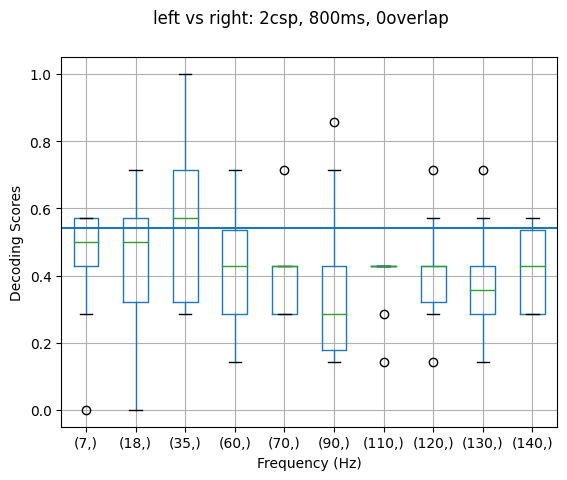

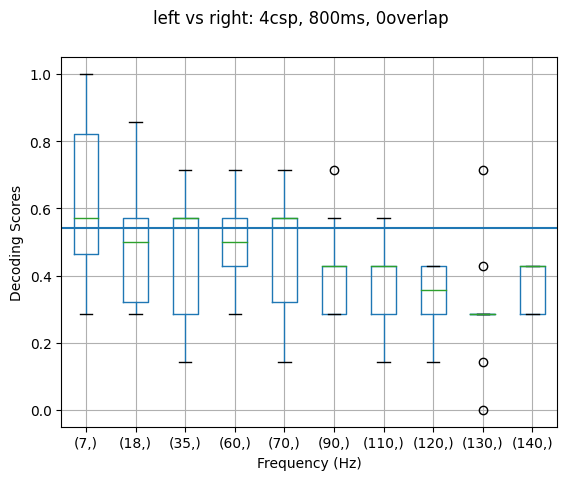

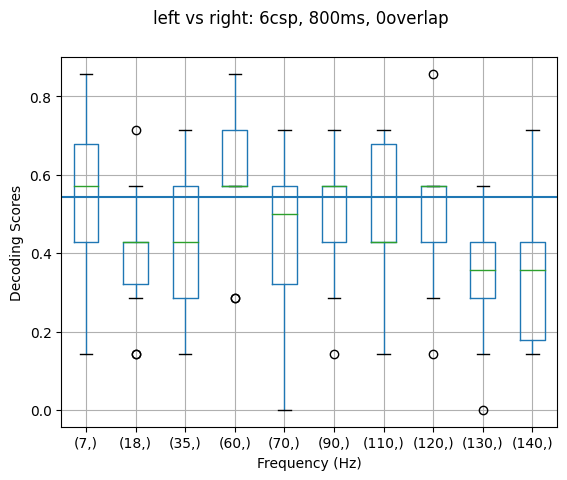

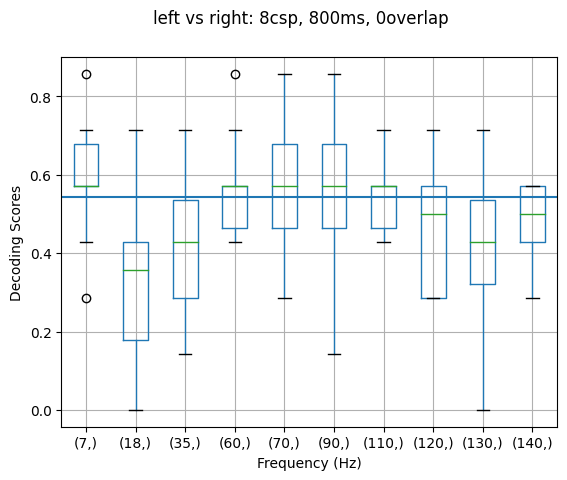

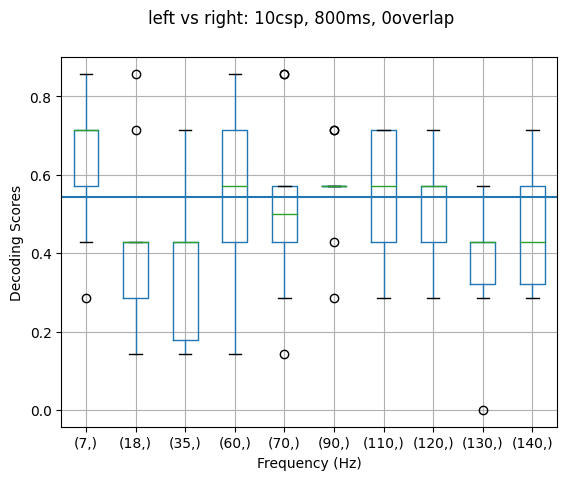

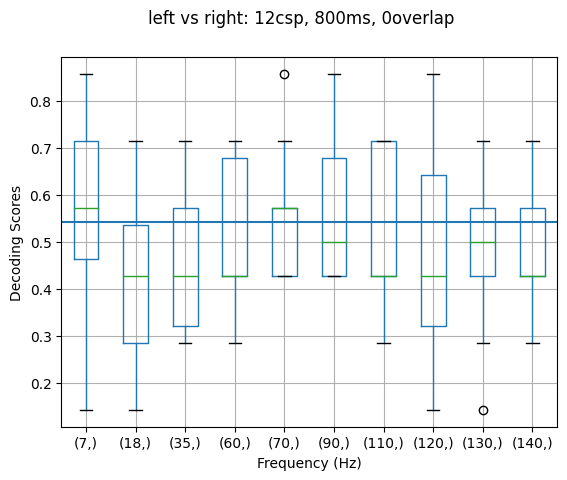

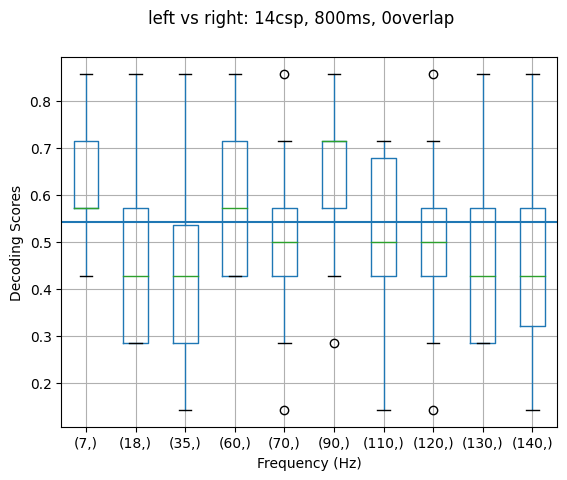

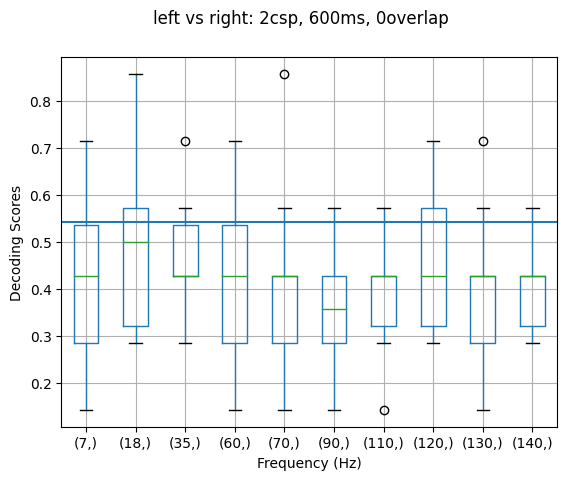

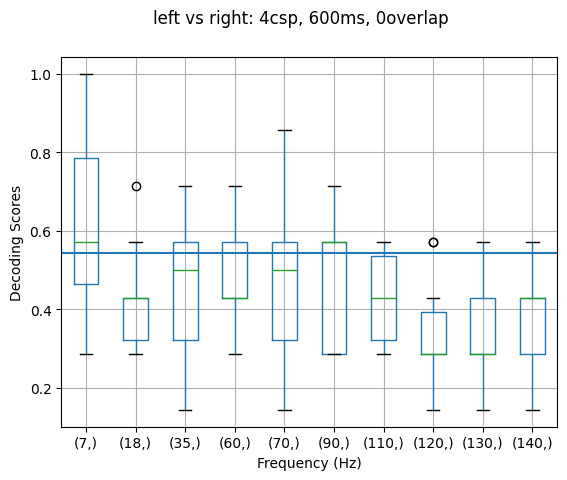

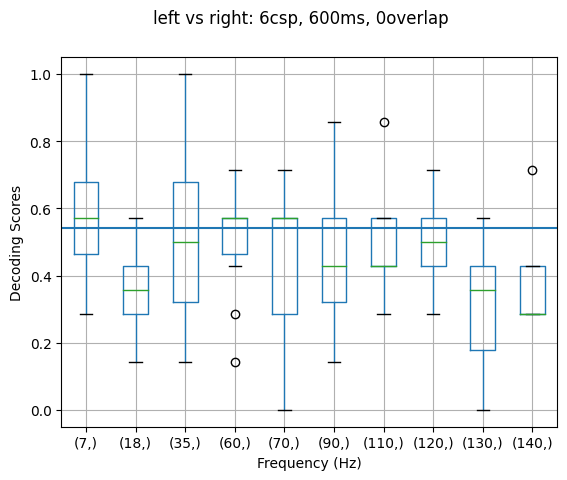

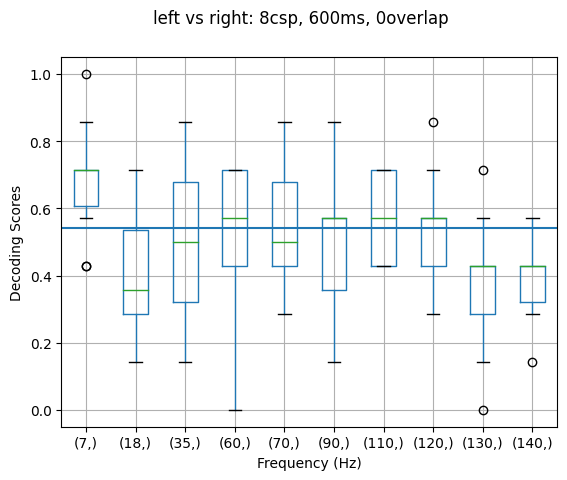

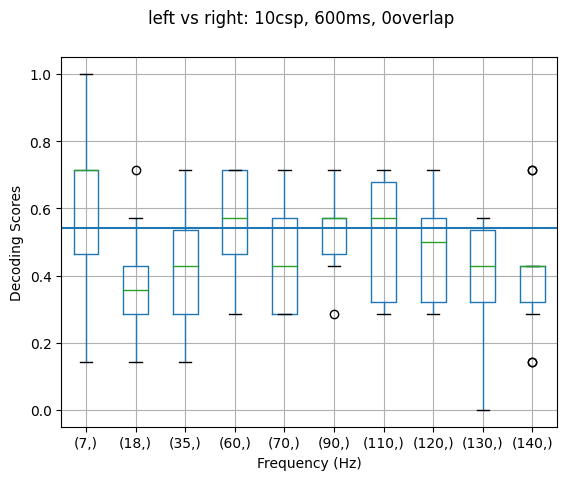

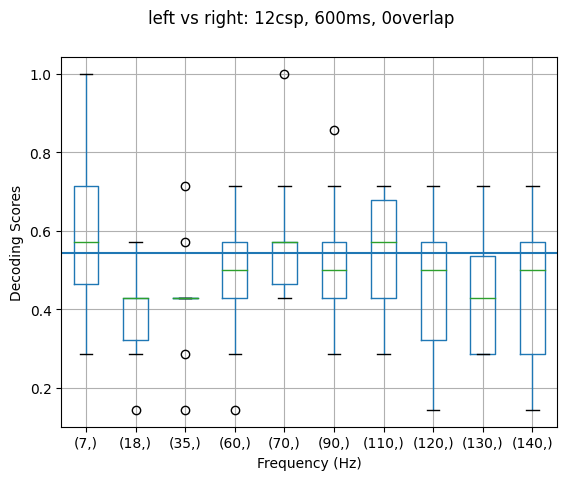

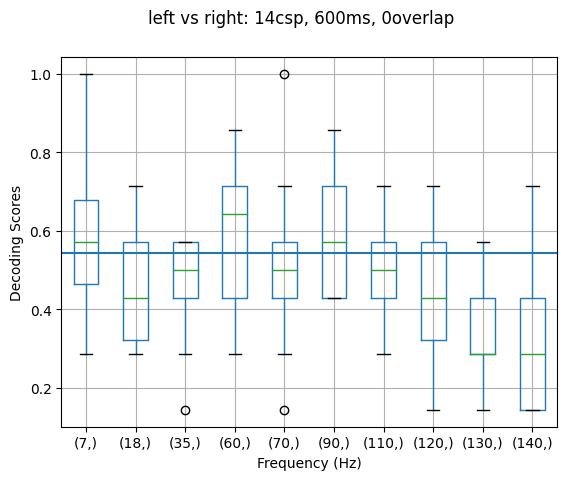

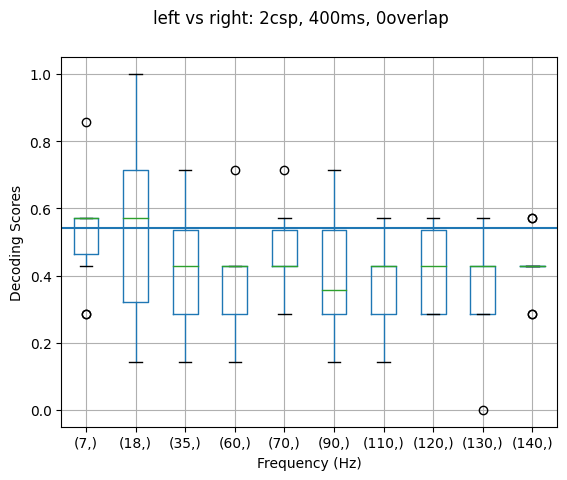

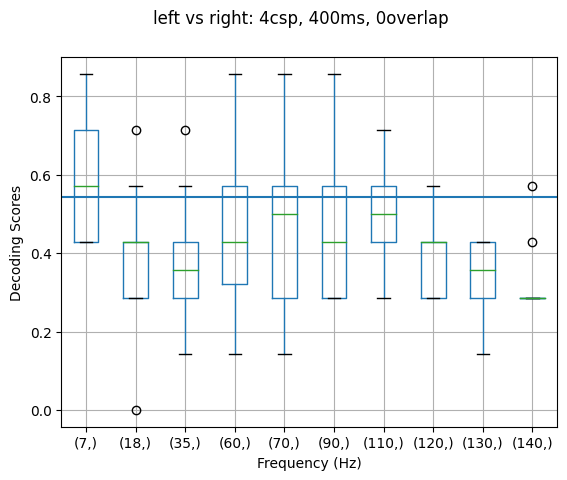

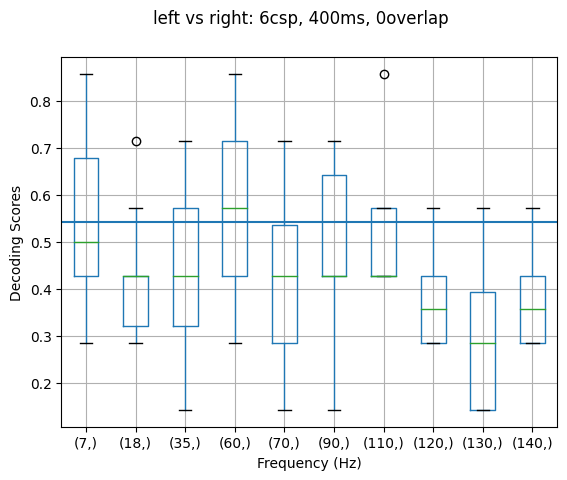

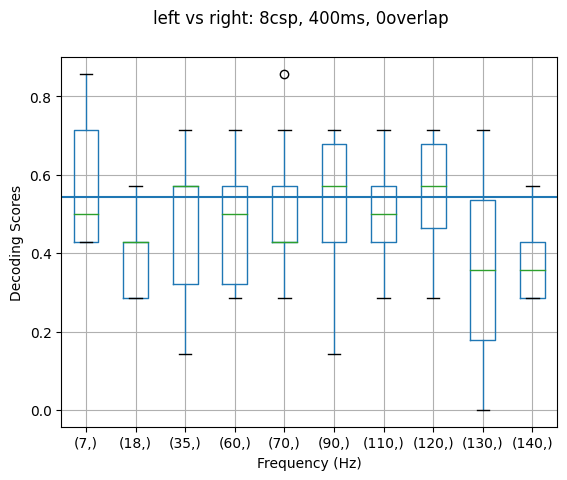

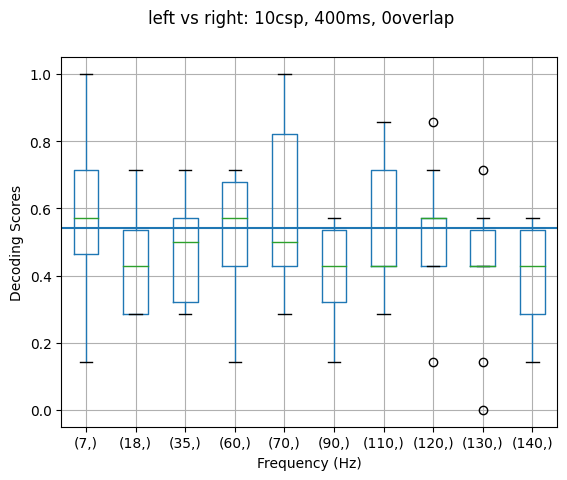

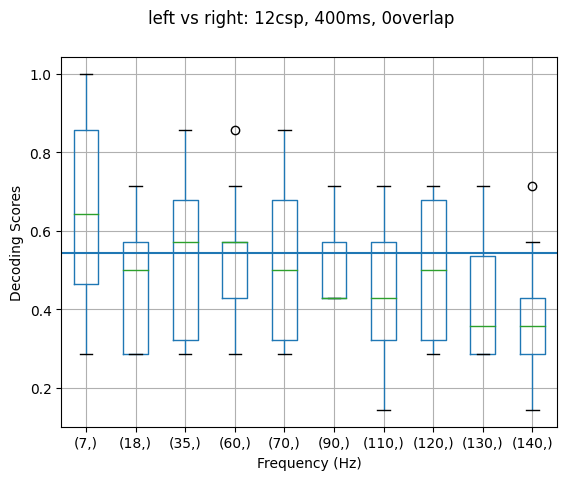

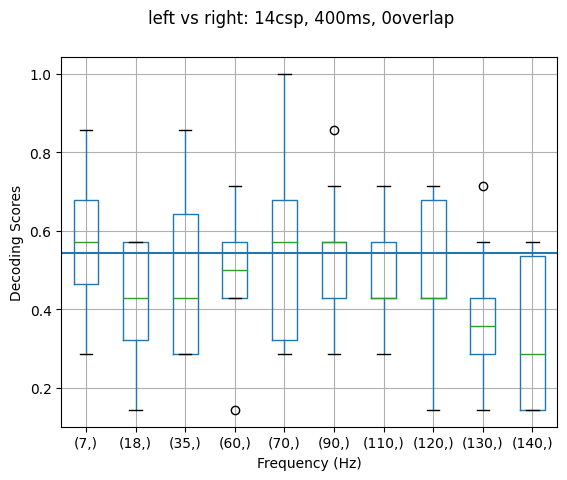

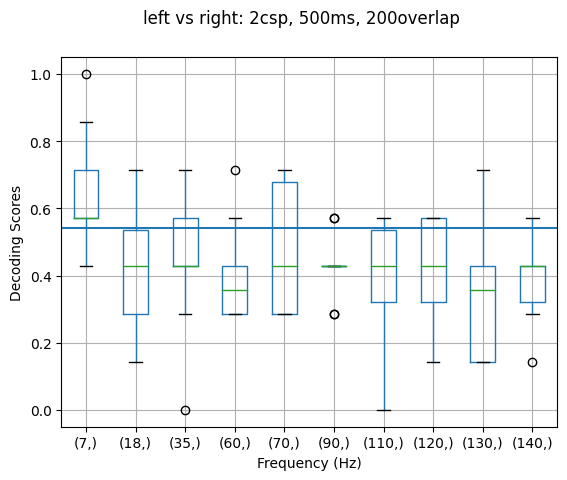

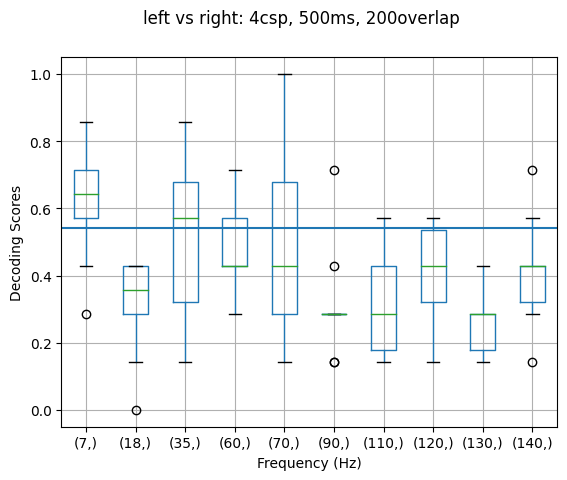

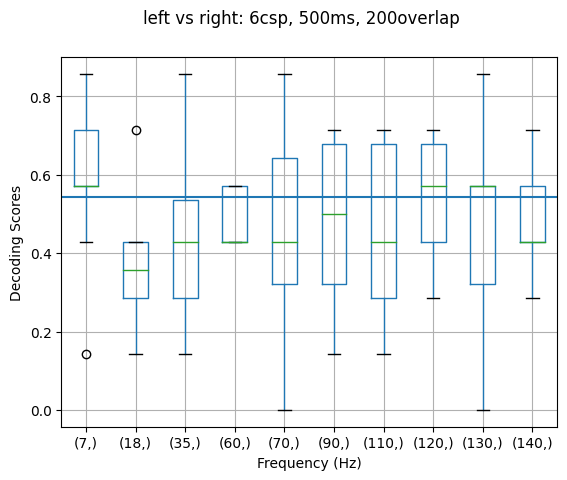

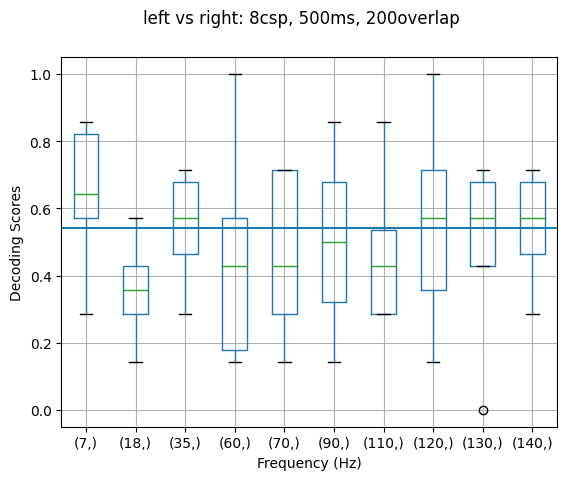

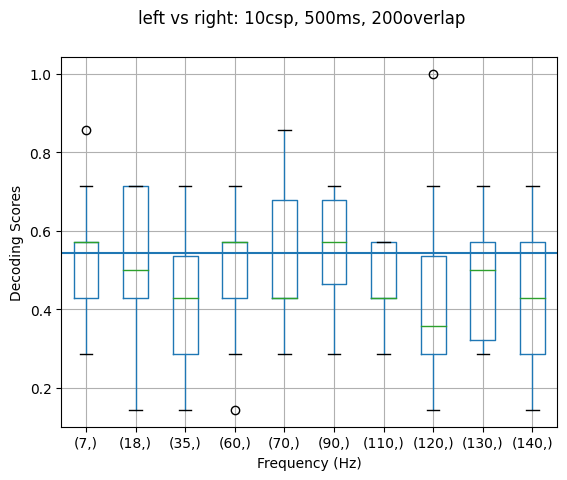

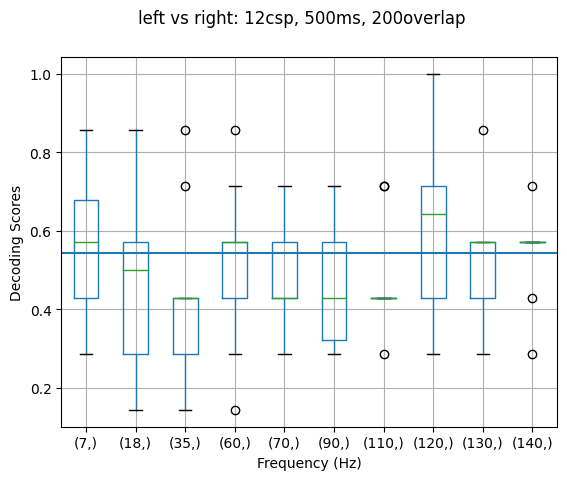

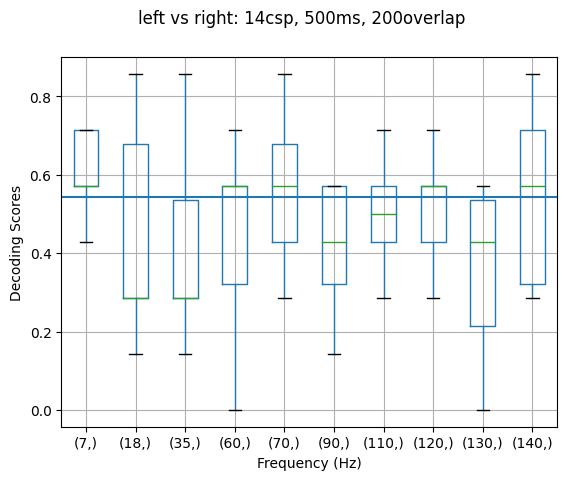

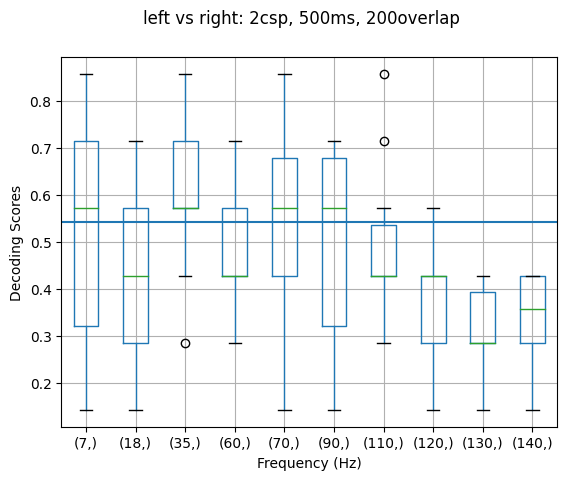

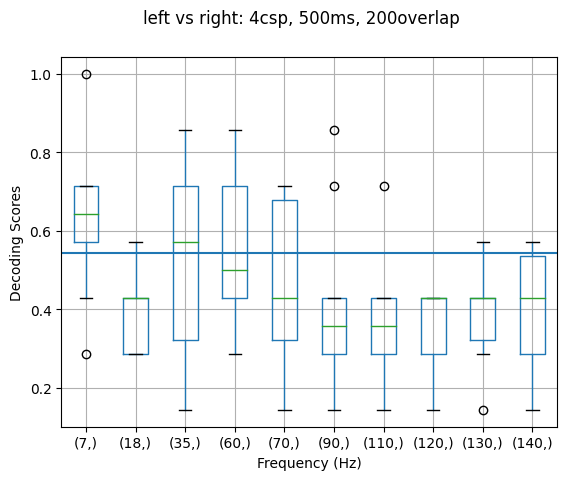

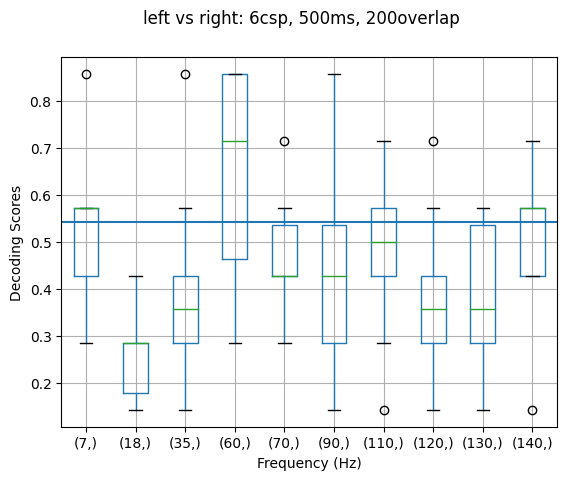

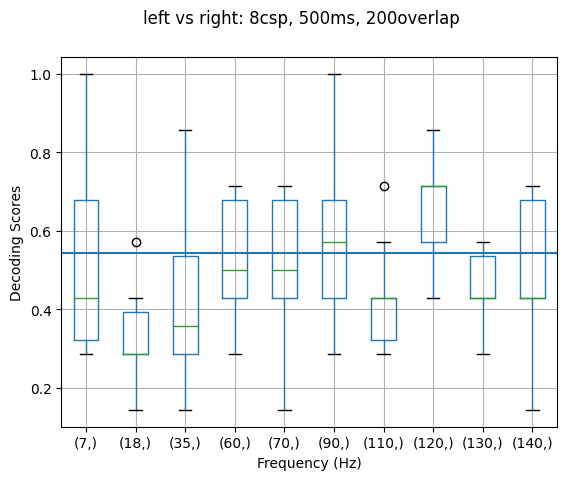

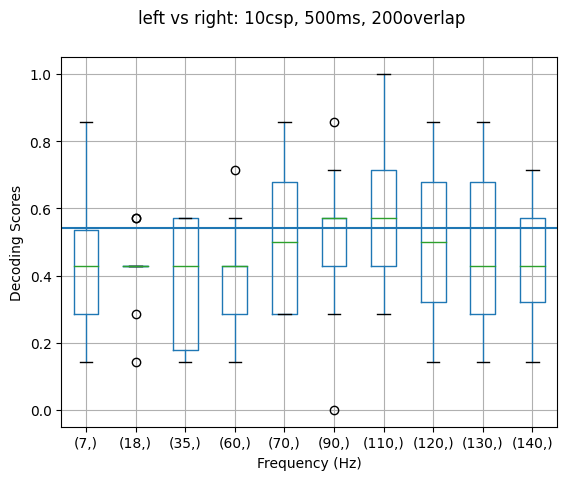

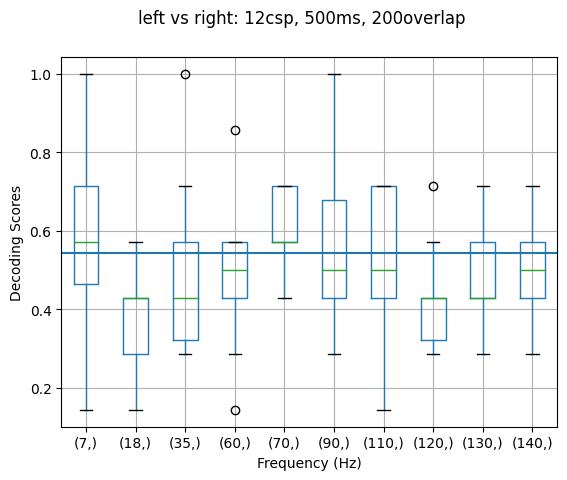

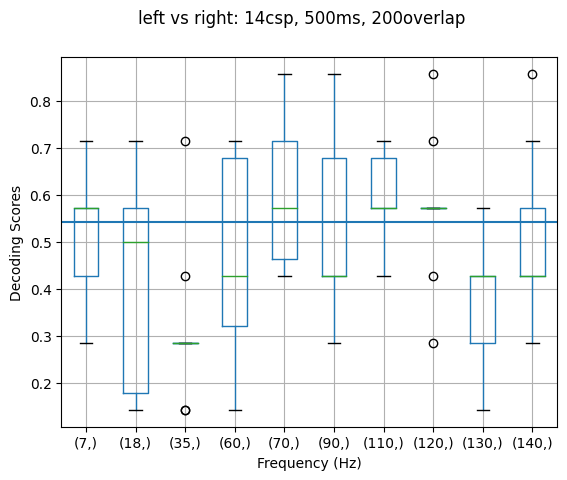

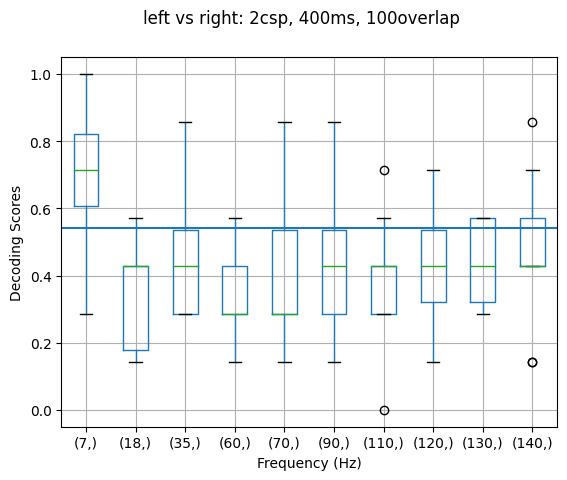

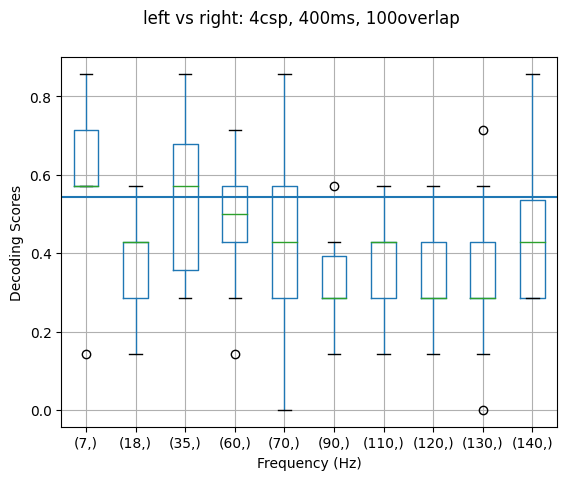

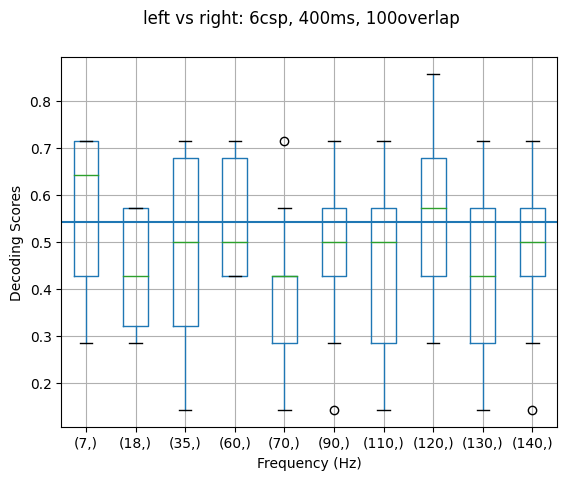

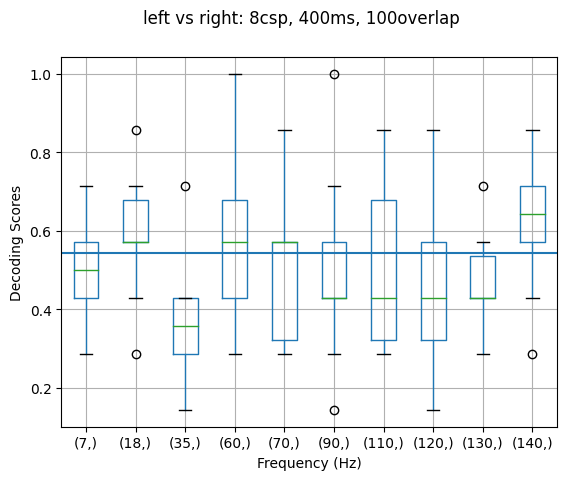

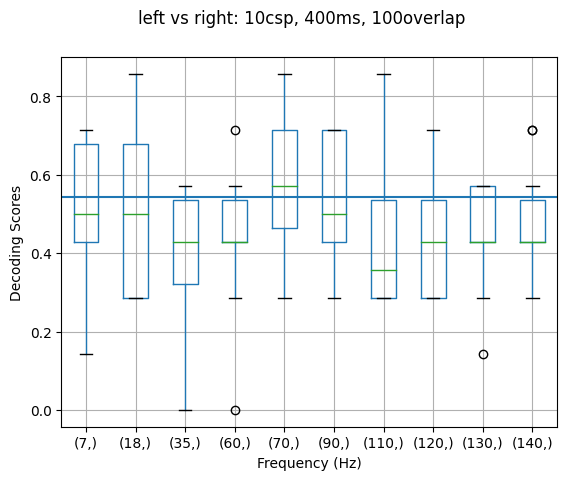

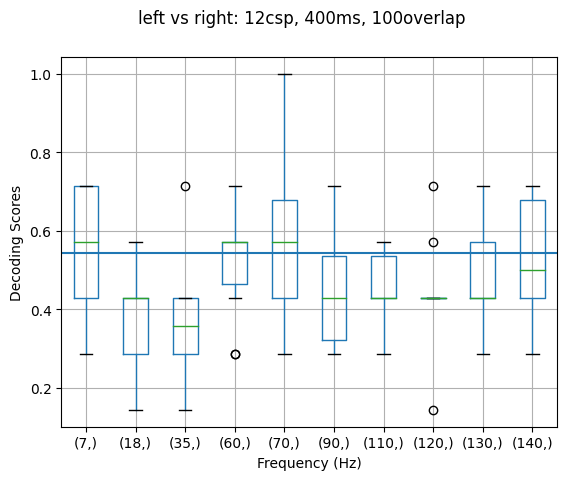

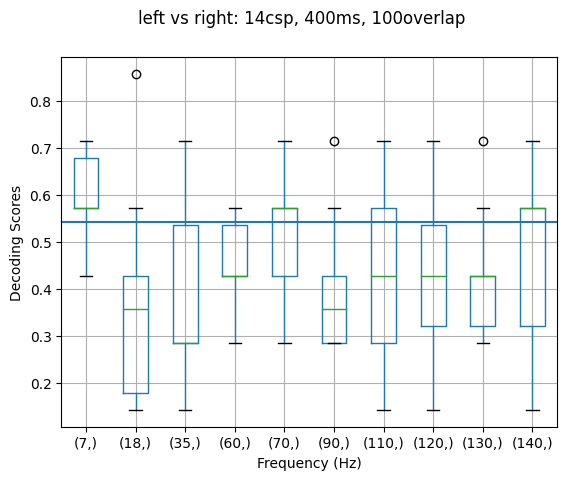

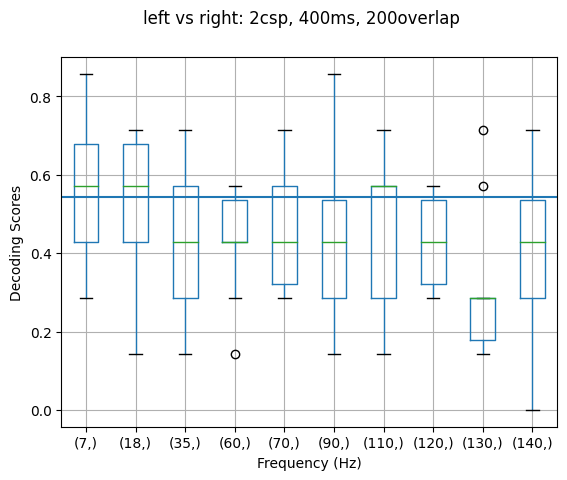

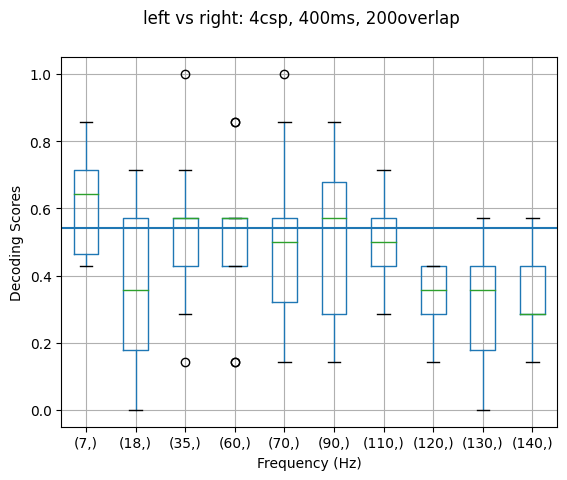

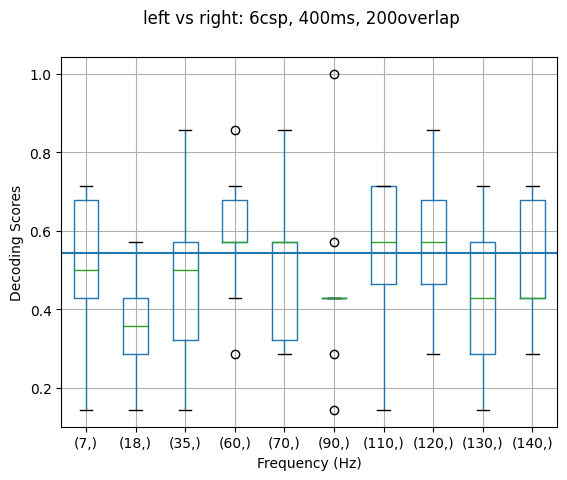

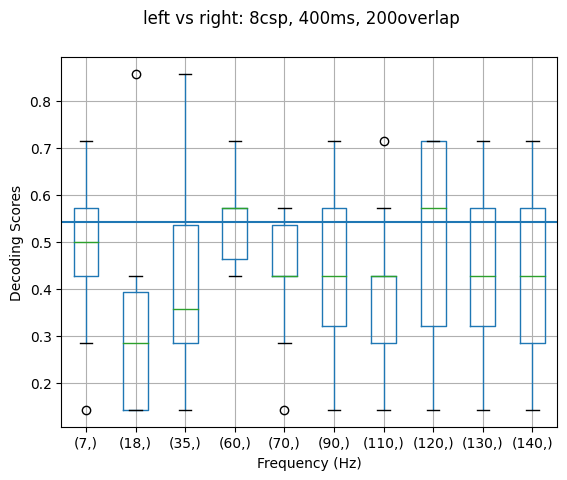

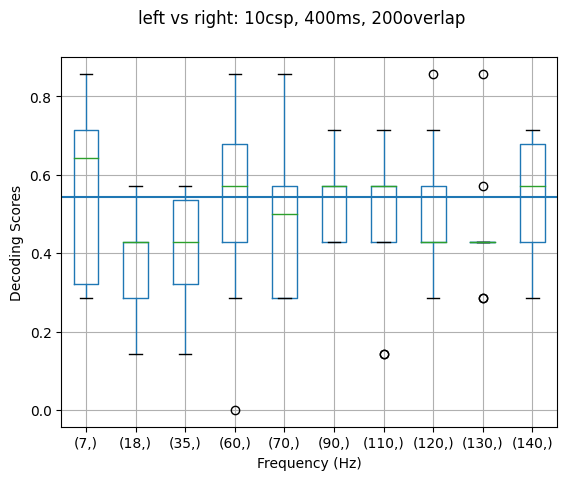

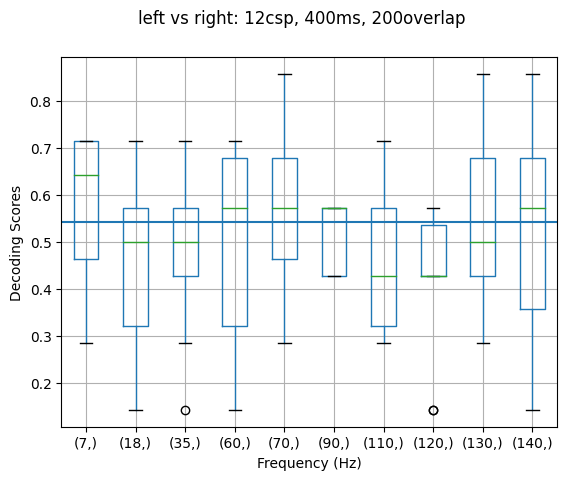

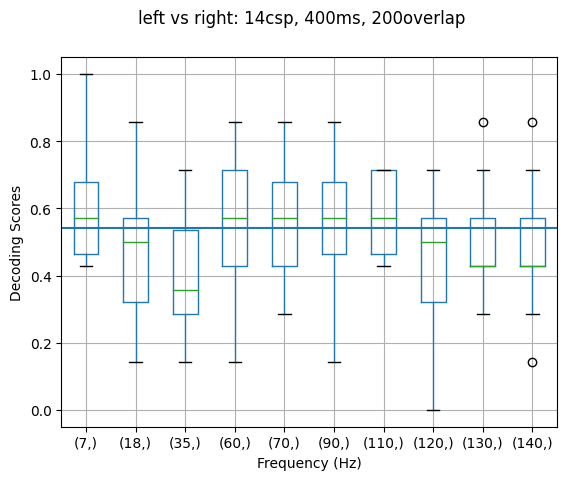

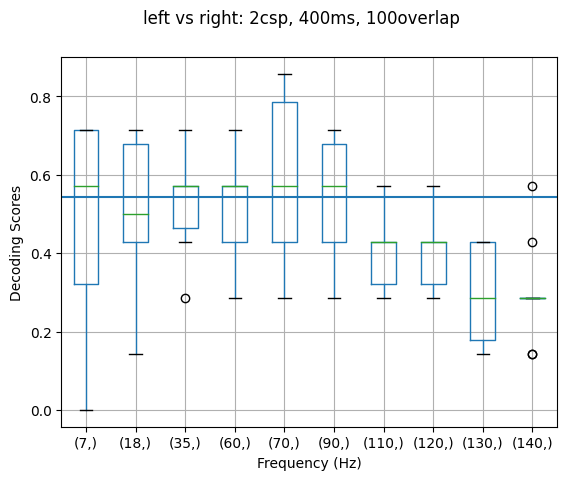

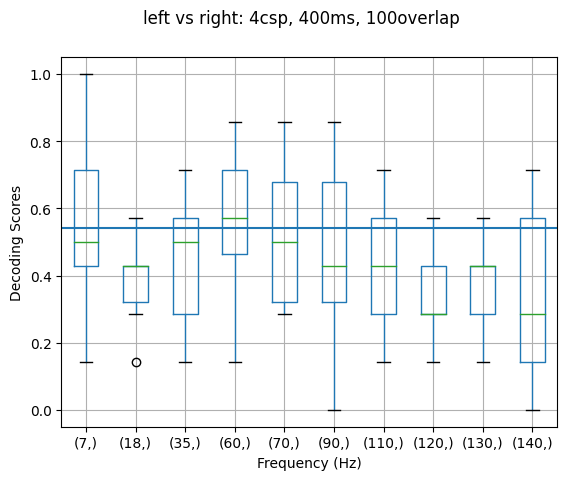

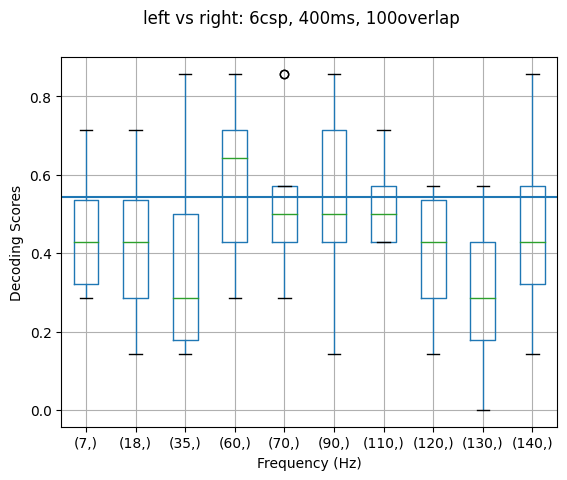

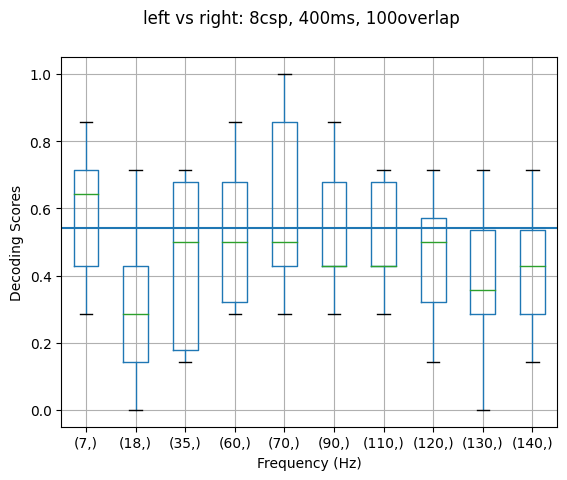

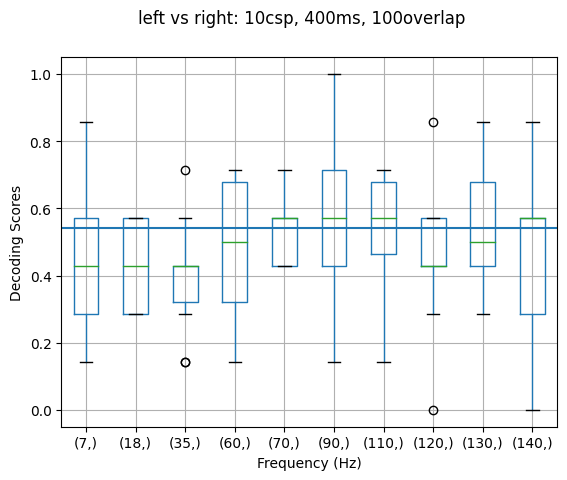

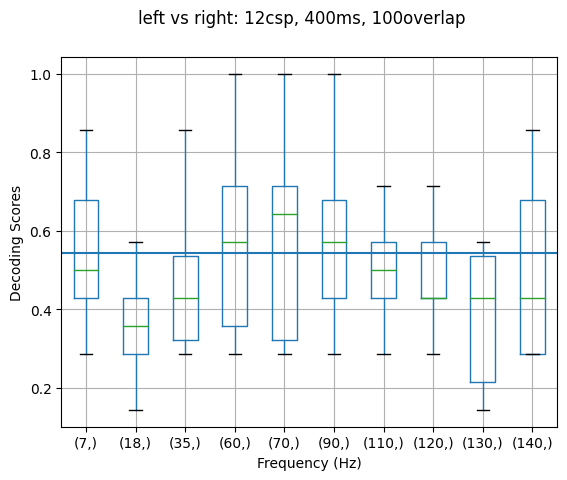

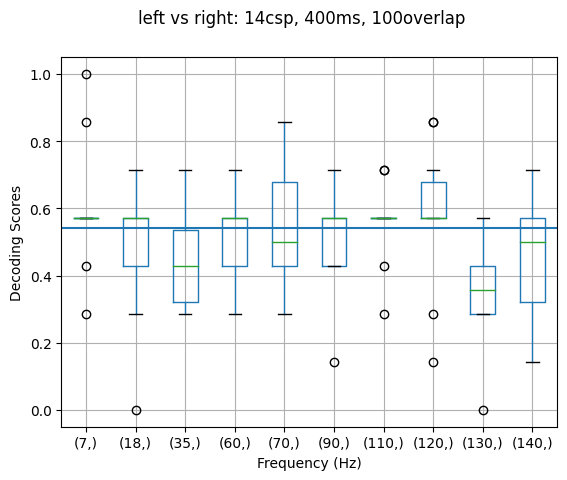

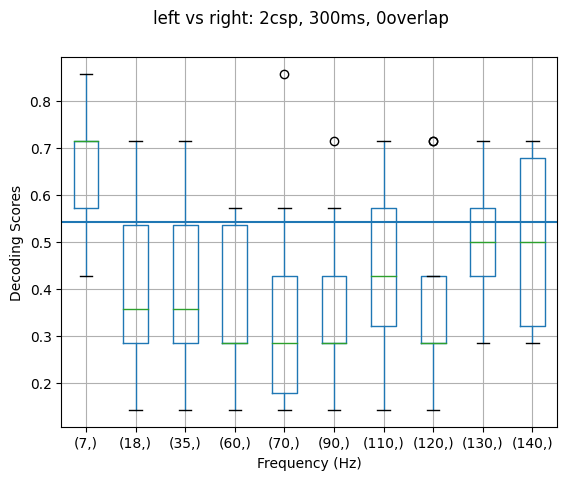

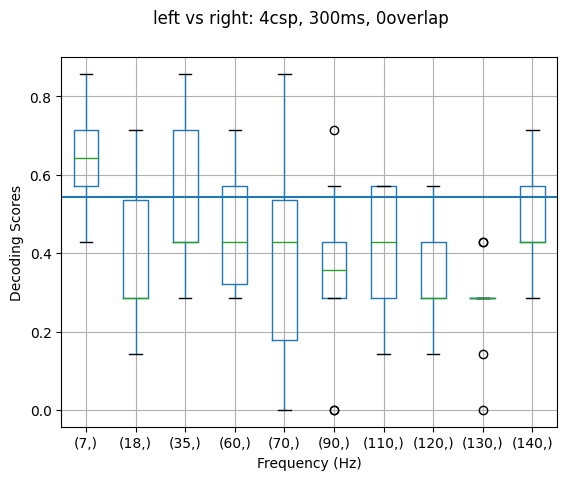

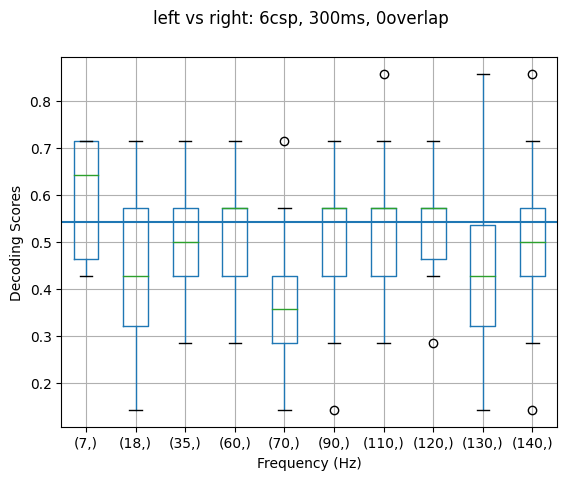

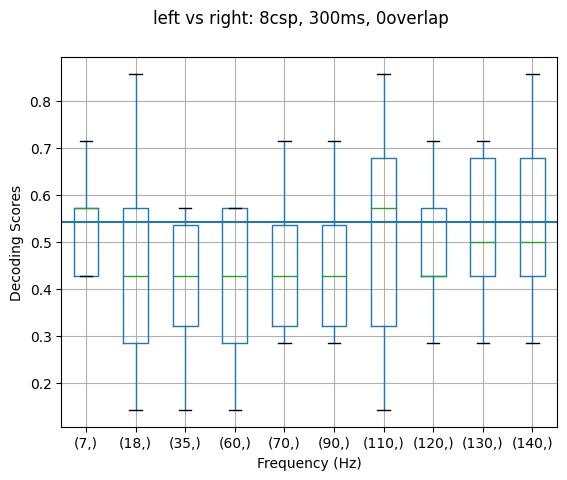

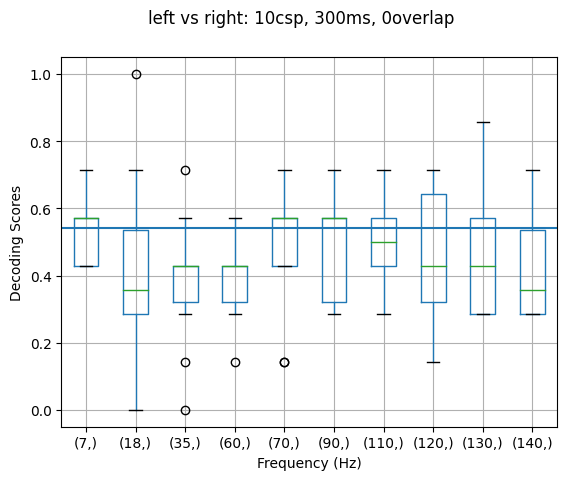

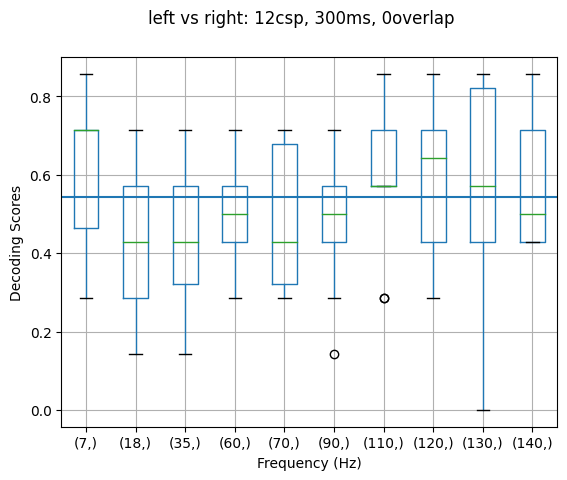

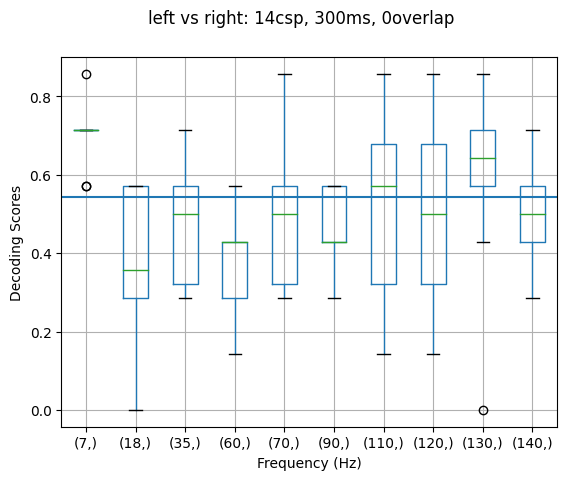

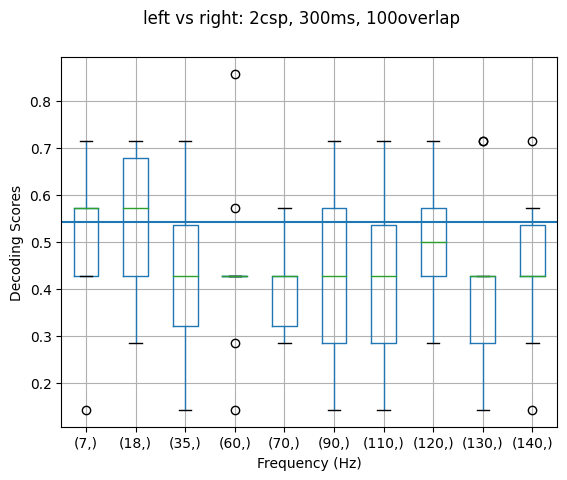

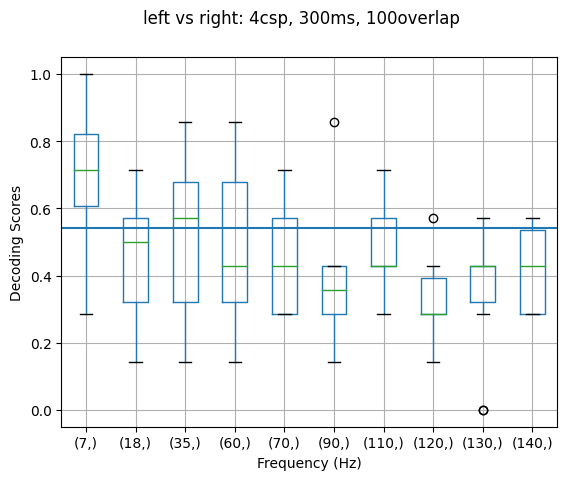

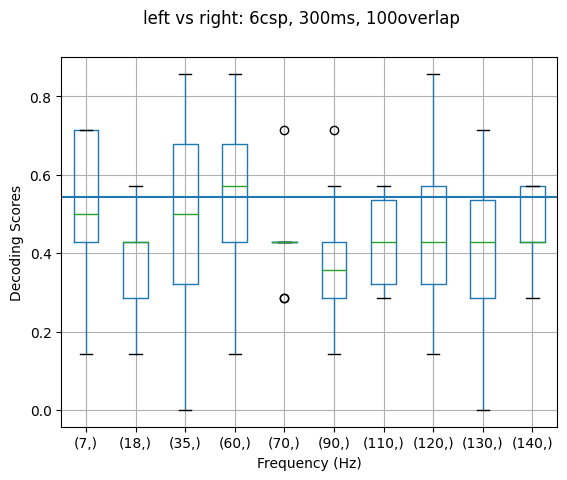

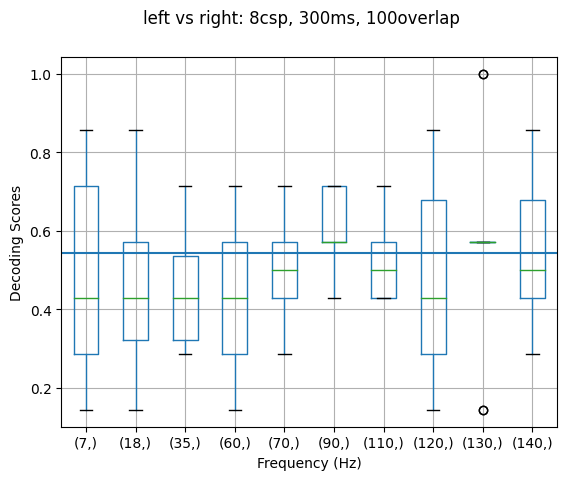

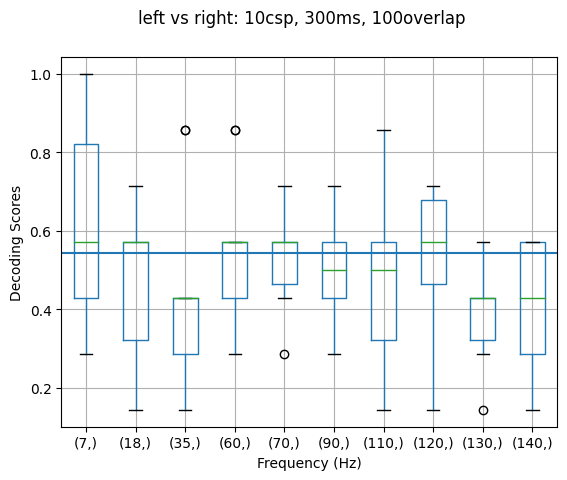

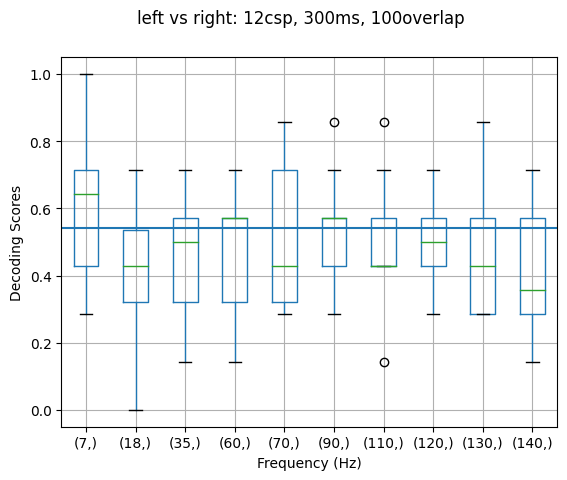

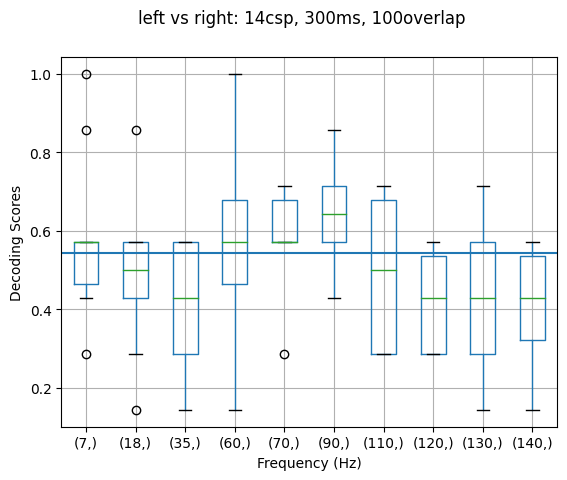

In [11]:
medians = []
i = 0
for cnf in time_config:
    n_windows, t_min, width, overlap = cnf
    j = 0
    cnf_medians = []
    for cmp in components:
        scores_df = pd.DataFrame(data=np.transpose(scores_arr[i,j]), columns=[freq_labels])
        csp_fig, axes = plt.subplots(1)
        scores_df.boxplot(ax=axes)
        axes.axhline(chance)
        axes.set_xlabel('Frequency (Hz)')
        axes.set_ylabel('Decoding Scores')
        csp_fig.suptitle('{} vs {}: {}csp, {}ms, {}overlap'.format(classes[0],classes[1],cmp,width,overlap))
        score_median = []
        for col in scores_df.columns:
            score_median.append(np.nanmedian(scores_df[col]))
        cnf_medians.append(score_median)
        j += 1
    medians.append(cnf_medians)
    i += 1

In [12]:
np.array(medians).shape
name = 'scores_1_{}_{}.npy'.format(classes[0],classes[1]) if chance < 0.565 else 'scores_1_UN_{}_{}.npy'.format(classes[0],classes[1])
np.save(name,np.array(medians))

Classification in different windows

In [15]:
chance

0.5333333333333333

C:\Users\Alberto\AppData\Local\Temp\ipykernel_18684\3218452850.py:3: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(0,1.6).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()


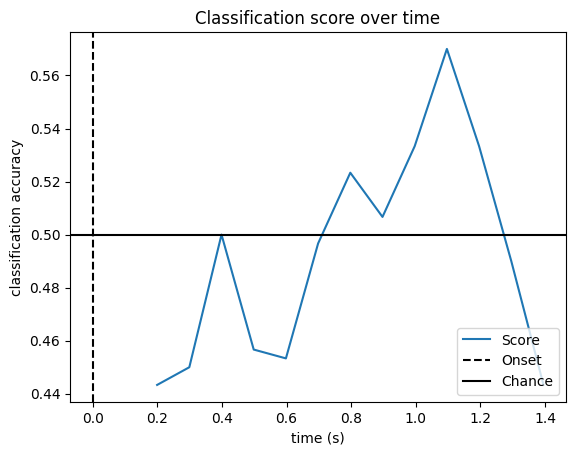

C:\Users\Alberto\AppData\Local\Temp\ipykernel_18684\3218452850.py:3: RuntimeWarning: filter_length (1691) is longer than the signal (1639), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(0,1.6).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()


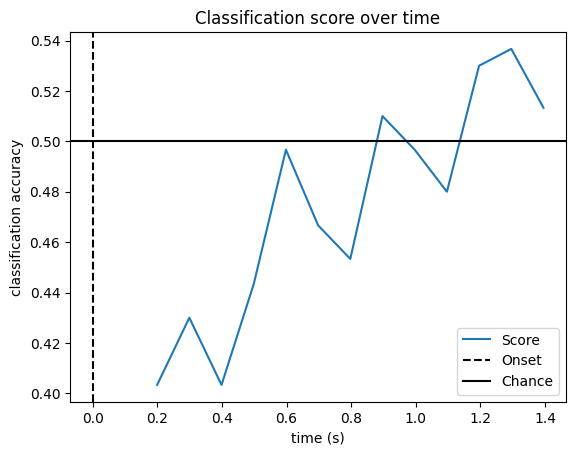

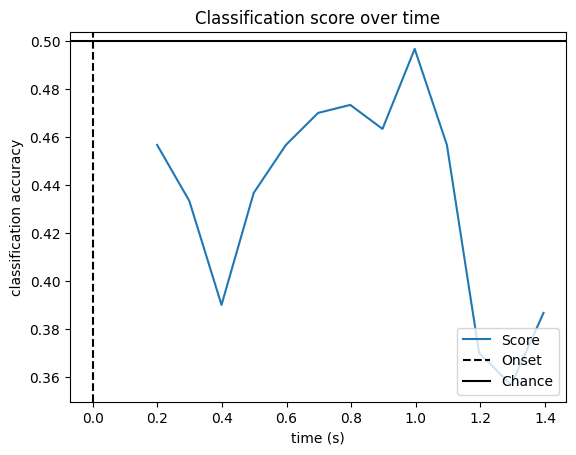

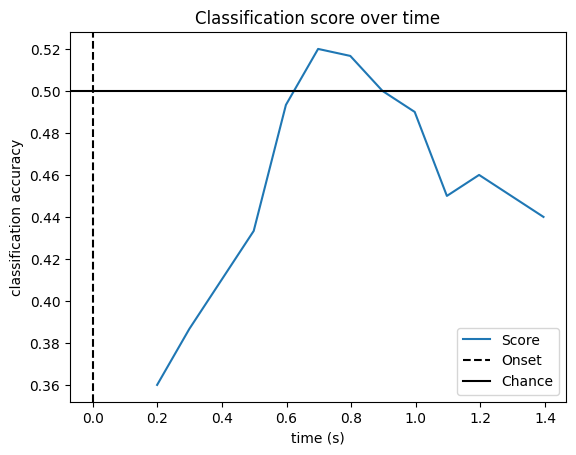

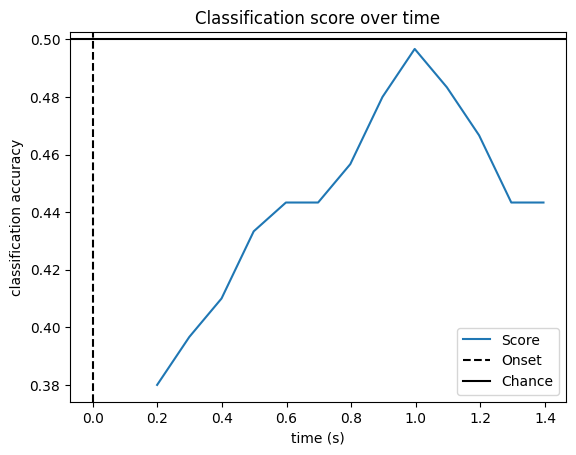

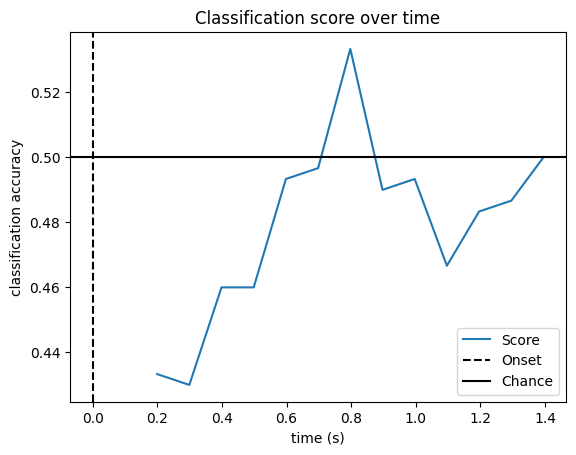

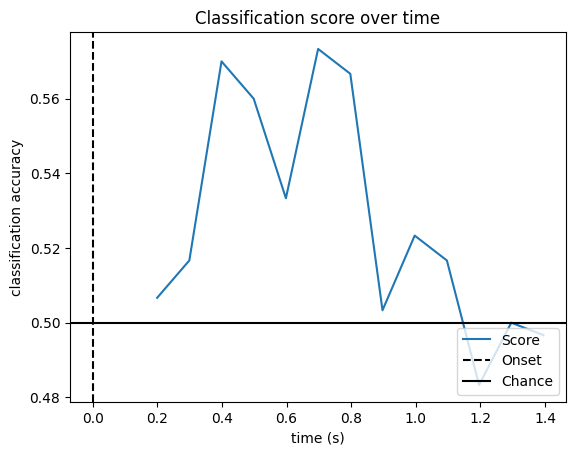

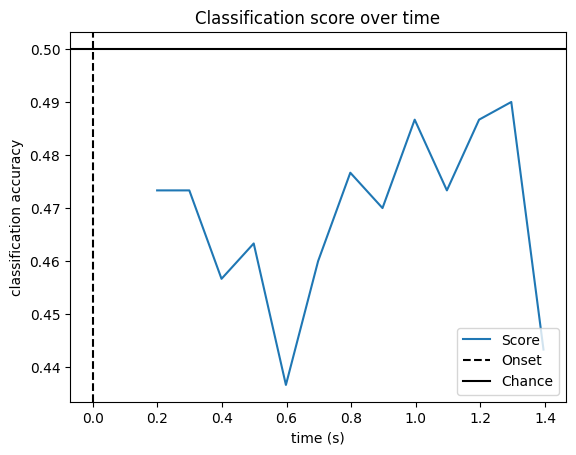

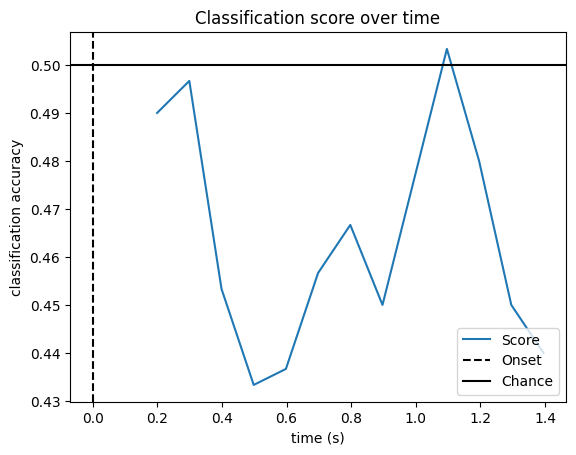

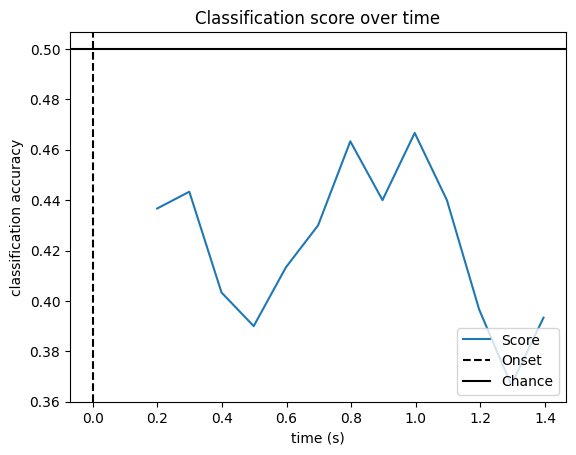

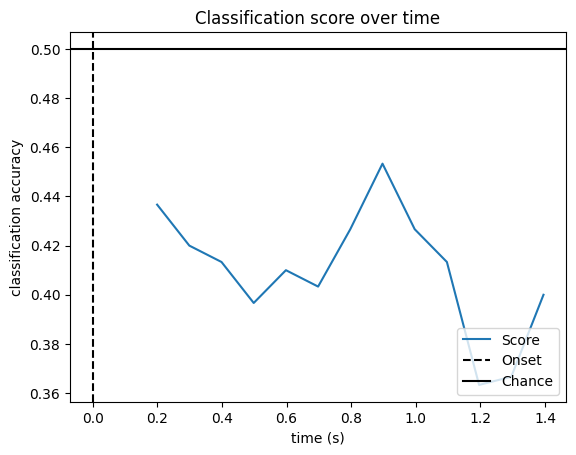

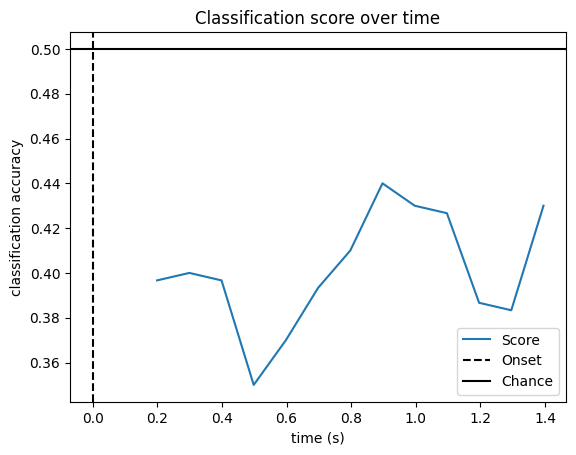

In [11]:
for freq, (fmin, fmax) in enumerate(freq_ranges):
    X = []
    test = subset.copy().crop(0,1.7).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
    cv_split = cv.split(test)
    
    sfreq = subset.info['sfreq']
    w_length = int(sfreq * 0.4)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, test.shape[2] - w_length, w_step)

    scores = []
    for train_idx, test_idx in cv_split:
        y_train, y_test = y[train_idx], y[test_idx]
        X_train = csp.fit_transform(test[train_idx], y_train)
        X_test = csp.transform(test[test_idx])
        lda.fit(X_train, y_train)
        
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(test[test_idx][:, :, n:(n + w_length)])
            score_this_window.append(lda.score(X_test, y_test))
        scores.append(score_this_window)
    
    freq_labels.append(str(int(fmax)))
    freq_scores.append(scores)    
    
    w_times = (w_start + w_length / 2.) / sfreq 

    
    plt.figure()
    plt.plot(w_times, np.mean(scores, 0), label='Score')
    plt.axvline(0, linestyle='--', color='k', label='Onset')
    plt.axhline(0.5, linestyle='-', color='k', label='Chance')
    plt.xlabel('time (s)')
    plt.ylabel('classification accuracy')
    plt.title('Classification score over time')
    plt.legend(loc='lower right')
    plt.show()
        
    

Classification along time and frecuencies

In [103]:
tmin, tmax = -.400, 1.8
n_cycles = 35.
n_frqs = 22

freqs = np.linspace(min_freq, max_freq, n_frqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

times = list()
centers = list()
window_spacing = 0.4
lcut = tmin

while lcut <= tmax-window_spacing:    
    rcut = lcut + window_spacing
    centers.append(rcut - window_spacing/2)  
    times.append((lcut,rcut))
    lcut += window_spacing/2

n_windows = len(centers)

In [104]:
tf_scores = np.zeros((n_frqs - 1, n_windows))
for freq, (fmin, fmax) in enumerate(freq_ranges):
    test = subset.copy().filter(fmin, fmax, n_jobs=4, verbose=False) 
    
    for i, window in enumerate(times):
        l_cut, r_cut = window  
        X = test.copy().crop(l_cut, r_cut).get_data()
        tf_scores[freq, i] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv, n_jobs=4))

NameError: name 'clf' is not defined

In [ ]:
av_tfr = AverageTFR(create_info(['sfreq'],subset.info['sfreq']), tf_scores[np.newaxis,:],
                   centers, freqs[1:],1)

In [ ]:
np.save(str(window_spacing)+'s_score_'+conditions[1]+'.npy', tf_scores)
av_tfr.plot([0], vmin=0.5, title=str(window_spacing)+"s Decoding Scores "+ conditions[0] + " vs " + conditions[1] ,
            cmap=plt.cm.Reds)

No baseline correction applied


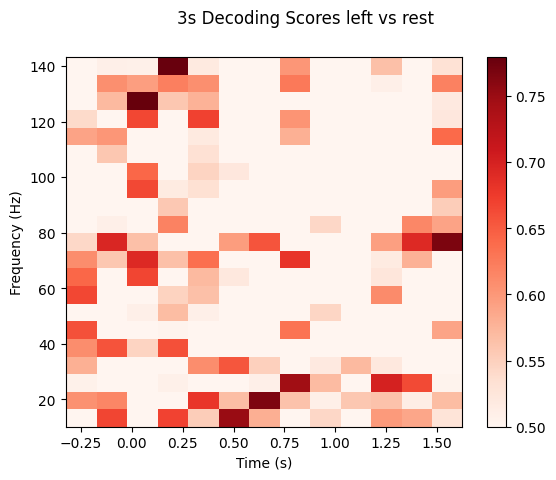

[<Figure size 640x480 with 2 Axes>]

In [41]:
np.save('3s_tf_ds.npy', tf_scores)
av_tfr.plot([0], vmin=0.5, title="3s Decoding Scores left vs rest",
            cmap=plt.cm.Reds)

No baseline correction applied


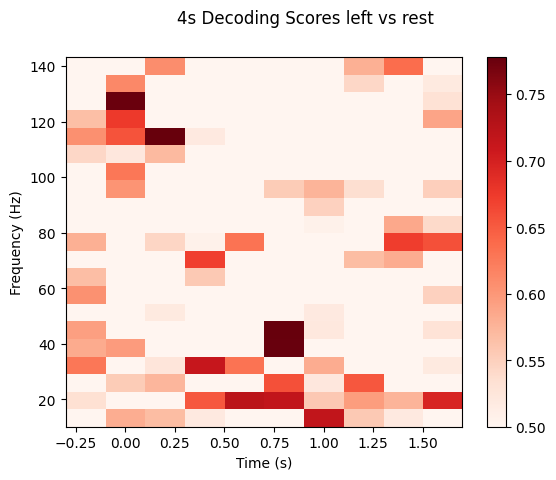

[<Figure size 640x480 with 2 Axes>]

In [48]:
np.save('4s_tf_ds.npy', tf_scores)
av_tfr.plot([0], vmin=0.5, title="4s Decoding Scores left vs rest",
            cmap=plt.cm.Reds)

No baseline correction applied


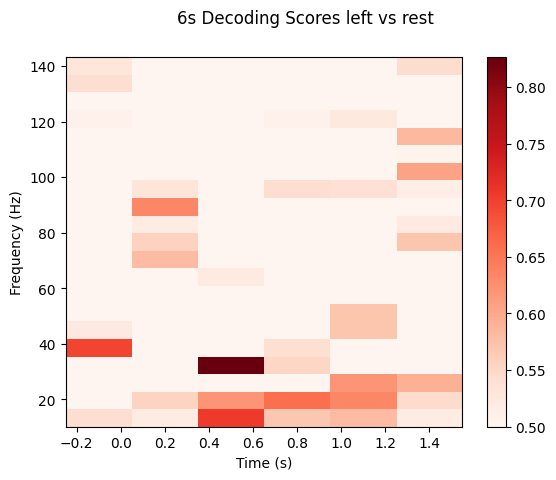

[<Figure size 640x480 with 2 Axes>]

In [52]:
np.save('6s_tf_ds.npy', tf_scores)
av_tfr.plot([0], vmin=0.5, title="6s Decoding Scores left vs rest",
            cmap=plt.cm.Reds)

No baseline correction applied


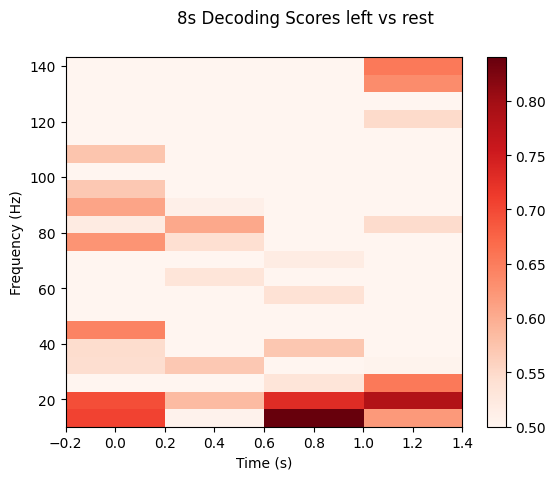

[<Figure size 640x480 with 2 Axes>]

In [56]:
np.save('8s_tf_ds.npy', tf_scores)
av_tfr.plot([0], vmin=0.5, title="8s Decoding Scores left vs rest",
            cmap=plt.cm.Reds)

No baseline correction applied


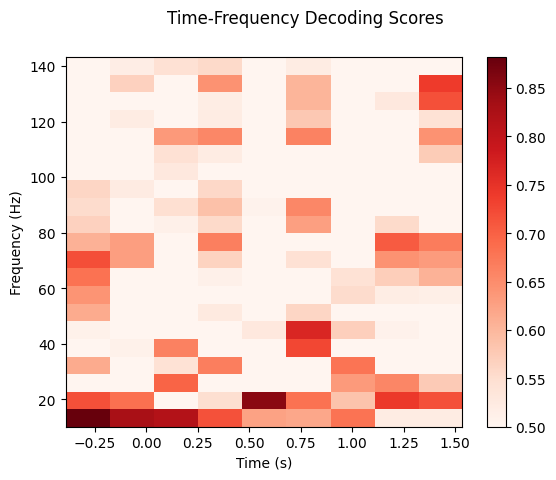

[<Figure size 640x480 with 2 Axes>]

In [106]:
av_tfr.plot([0], vmin=0.5, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)